In [1]:
%cd /content/drive/MyDrive/project-fabriq/Prelims/sd-controlnet/ControlNet/

/content/drive/MyDrive/project-fabriq/Prelims/sd-controlnet/ControlNet


In [ ]:
!git clone https://github.com/lllyasviel/ControlNet.git

Cloning into 'ControlNet'...
remote: Enumerating objects: 1356, done.
remote: Total 1356 (delta 0), reused 0 (delta 0), pack-reused 1356 (from 1)
Receiving objects: 100% (1356/1356), 122.40 MiB | 14.79 MiB/s, done.
Resolving deltas: 100% (596/596), done.
Updating files: 100% (509/509), done.


In [3]:
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 59.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitli

In [4]:
!pip install open_clip_torch==2.0.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.9 MB/s eta 0:00:00


In [2]:
import config
import cv2
import einops
import numpy as np
import torch
import random
from pytorch_lightning import seed_everything
from annotator.util import resize_image, HWC3
from cldm.model import create_model, load_state_dict
from cldm.ddim_hacked import DDIMSampler

In [3]:
model = create_model(
    "/content/drive/MyDrive/project-fabriq/Prelims/sd-controlnet/ControlNet/models/cldm_v15.yaml",
).cpu()

No module 'xformers'. Proceeding without it.
ControlLDM: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loaded model config from [/content/drive/MyDrive/project-fabriq/Prelims/sd-controlnet/ControlNet/models/cldm_v15.yaml]


In [4]:
model.load_state_dict(load_state_dict('../control_sd15_scribble.pth', location='cuda'), strict=False)
model = model.cuda()

Loaded state_dict from [../control_sd15_scribble.pth]


In [5]:
ddim_sampler = DDIMSampler(model)

In [6]:
def process(input_image, prompt, a_prompt, n_prompt, num_samples, image_resolution, ddim_steps, guess_mode, strength, scale, seed, eta):
    with torch.no_grad():
        img = resize_image(HWC3(input_image), image_resolution)
        H, W, C = img.shape

        detected_map = np.zeros_like(img, dtype=np.uint8)
        detected_map[np.min(img, axis=2) < 127] = 255

        control = torch.from_numpy(detected_map.copy()).float().cuda() / 255.0
        control = torch.stack([control for _ in range(num_samples)], dim=0)
        control = einops.rearrange(control, 'b h w c -> b c h w').clone()

        if seed == -1:
            seed = random.randint(0, 65535)
        seed_everything(seed)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        cond = {"c_concat": [control], "c_crossattn": [model.get_learned_conditioning([prompt + ', ' + a_prompt] * num_samples)]}
        un_cond = {"c_concat": None if guess_mode else [control], "c_crossattn": [model.get_learned_conditioning([n_prompt] * num_samples)]}
        shape = (4, H // 8, W // 8)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=True)

        model.control_scales = [strength * (0.825 ** float(12 - i)) for i in range(13)] if guess_mode else ([strength] * 13)  # Magic number. IDK why. Perhaps because 0.825**12<0.01 but 0.826**12>0.01
        samples, intermediates = ddim_sampler.sample(ddim_steps, num_samples,
                                                     shape, cond, verbose=False, eta=eta,
                                                     unconditional_guidance_scale=scale,
                                                     unconditional_conditioning=un_cond)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        x_samples = model.decode_first_stage(samples)
        x_samples = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)

        results = [x_samples[i] for i in range(num_samples)]
    return [255 - detected_map] + results

In [17]:
input_image = "/content/drive/MyDrive/project-fabriq/Prelims/stylegan2-ada-pytorch/out_biked/seed0008.png"
img = cv2.imread(input_image)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

results = process(
    input_image=img,
    prompt="Convert this design into a real cycle with proper black cycle seat, bars and rods.",
    a_prompt="Include a water bottle holder in front of the cycle",
    n_prompt="Don't change the structure of the cycle",
    num_samples=4,
    image_resolution=512,
    ddim_steps=20,
    guess_mode=False,
    strength=1.0,
    scale=9.0,
    seed=12345,
    eta=1.0,
)

INFO:lightning_fabric.utilities.seed:Seed set to 12345


Data shape for DDIM sampling is (4, 4, 64, 64), eta 1.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [01:02<00:00,  3.12s/it]


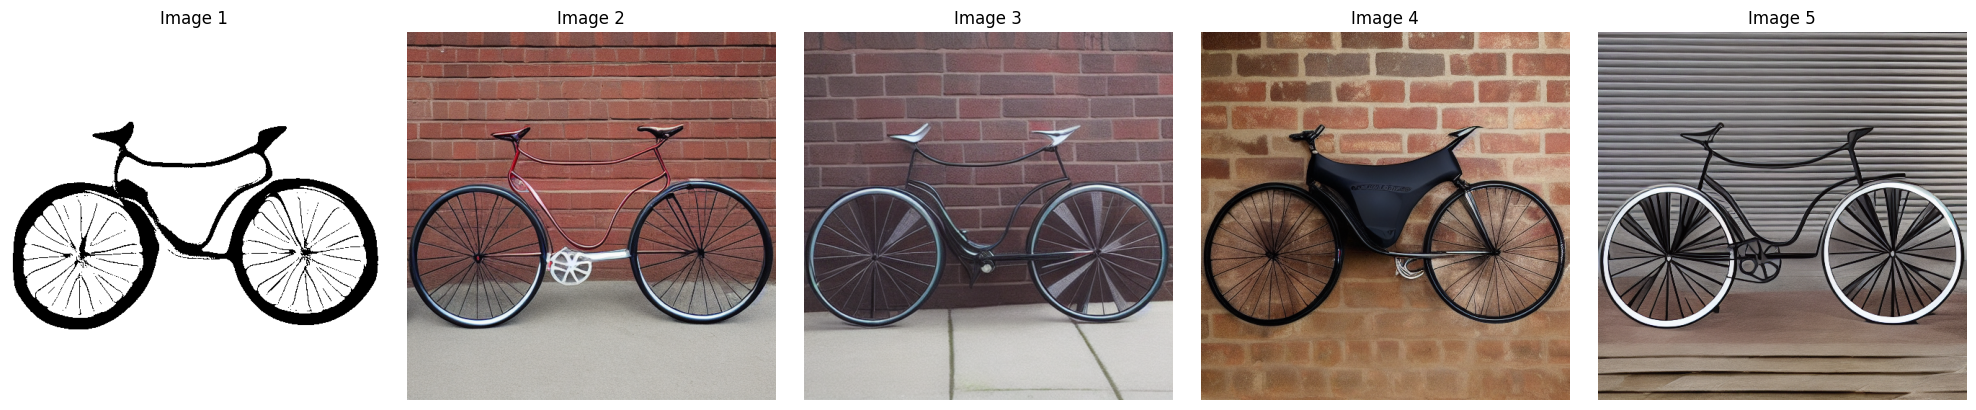

In [18]:
import matplotlib.pyplot as plt

rows = 1
cols = len(results)
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4))

for i, img in enumerate(results):
    ax = axes[i] if cols > 1 else axes
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(f"Image {i+1}")

plt.tight_layout()
plt.show()

In [11]:
input_image = "/content/drive/MyDrive/project-fabriq/Prelims/sketch.jpg"
img = cv2.imread(input_image)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

results = process(
    input_image=img,
    prompt="Convert this sketch into a real cycle with proper black cycle seat, bars and rods.",
    a_prompt="Insert a garden background",
    n_prompt="Don't change the structure of the cycle",
    num_samples=4,
    image_resolution=512,
    ddim_steps=20,
    guess_mode=True,
    strength=1.0,
    scale=9.0,
    seed=12345,
    eta=1.0,
)

INFO:lightning_fabric.utilities.seed:Seed set to 12345


Data shape for DDIM sampling is (4, 4, 64, 88), eta 1.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:47<00:00,  2.39s/it]


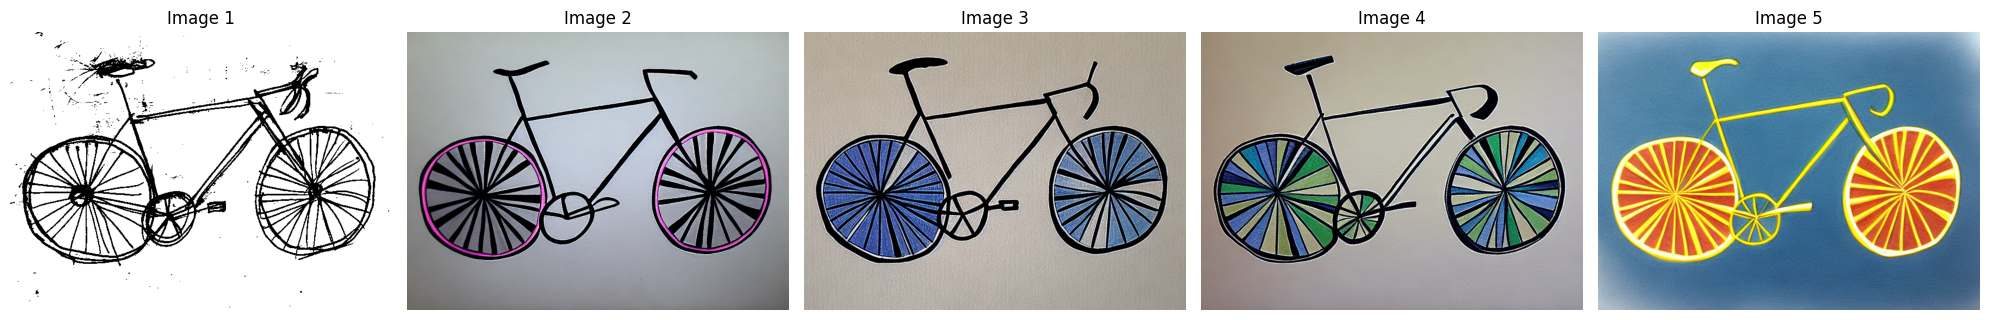

In [12]:
import matplotlib.pyplot as plt

rows = 1
cols = len(results)
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4))

for i, img in enumerate(results):
    ax = axes[i] if cols > 1 else axes
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(f"Image {i+1}")

plt.tight_layout()
plt.show()